<a href="https://colab.research.google.com/github/ozlemyasar/Coevolution-of-reciprocity-and-trust/blob/main/abm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
using Clp
using DataFrames
using Distributions
using LinearAlgebra
using Ranges
using Random
using Agents
using DrWatson: @dict
using InteractiveDynamics
using Plots
using StatsPlots
using CSV

In [ ]:
a = 4
b = 20

random_trust = Beta(a, b)
average_trust = a / (a+b)

0.16666666666666666

RType indicates:
1. 1 = Altruist
2. 2 = Vulnerable-Responsive
3. 3 = Selfish


In [ ]:
Personas = [1, 2, 3]

3-element Vector{Int64}:
 1
 2
 3

In [ ]:
mutable struct Agent <: AbstractAgent
    id::Int                # The identifier number of the agent
    pos::NTuple{2,Float64} # The x, y location of the agent on a 2D grid
    persona::Int           # Type of agent: 1=Altrust, 2=Vulnerable-Responsive, 3=Selfish
    trust::Float64         # Between 0 and 1. 0 means no trust while 1 means perfect trust
    energy::Float64        # Cumulation of payoffs
    last_ft_action::Int
    last_st_action::Int
    last_payoff::Float64
    turn_order::Int
    summary::Vector{Float64}# A list of eyetype, shade and color, respectively. 
end

In [ ]:
function model_initiation(;
    numagents = 240,
    pcc = 1,
    pdc = 2,
    pcd = -2,
    pdd = -1,
    mutation_rate = 0.1,
    extent = (2, 2),
    spacing = 1,
	seed = 3,
    average_trust = 0.5,
    trust_parameter = 0.1,
    param_a =1.0,
    param_v =0.8
)

    rng = Random.MersenneTwister(seed)
    properties = @dict(
        numagents,
        pcc,
        pdc,
        pcd,
        pdd,
        mutation_rate,
        average_trust,
        trust_parameter,
        param_a,
        param_v
    )
    
    space2d = ContinuousSpace(extent, spacing)
	model = ABM(Agent, space2d; properties, rng, scheduler = Schedulers.Randomly())

    for n in 1:numagents
		pos = random_position(model)
		persona = Personas[mod(n-1, 3)+1]
		trust = rand(random_trust, 1)[1]
		last_ft_action = 0
		last_st_action = 0
        last_payoff = 0.0
        turn_order = 0
        energy = 0.0
        agent = Agent(
			n,
			pos,
			persona,
			trust,
            energy,
			last_ft_action,
            last_st_action,
            last_payoff,
            turn_order,
            [persona, trust]
		)
        
		add_agent!(agent, model)
    end

    return model
end

model_initiation (generic function with 1 method)

In [ ]:
function model_step!(model)
	

    for (a1, a2) in list_pairs(model)
        game!(a1, a2, model)
    end
    
    for a in allagents(model)
        
        mu_rate = model.mutation_rate

        self_payoff = a.last_payoff
        random_opponent = random_agent(model)
        opp_payoff = random_opponent.last_payoff
        imit_prob = 1 / (1 + exp((self_payoff - opp_payoff)/mu_rate))
        
        if a.turn_order == 1
            a.trust = a.trust + model.trust_parameter * a.trust * (a.last_payoff - model.pdd)
            if a.trust > 1
                a.trust =1
            elseif a.trust<0
                a.trust =0
            end
        end
        
        if a.turn_order == 2
            if imit_prob > 1 - rand()
                a.persona = random_opponent.persona
            end
        end
    end
    # Bacteria can interact with more than on other cell at the same time, therefore,
    # we need to specify the option `:all` in `interacting_pairs`
    
end

model_step! (generic function with 1 method)

In [ ]:
function list_pairs(model)
    
    pair_list = []
    shuffled_list = shuffle([a for a in allagents(model)])
    for a in 1:2:model.numagents
        push!(pair_list, (shuffled_list[a], shuffled_list[a+1]))
    end
    return pair_list
end

list_pairs (generic function with 1 method)

In [ ]:
function game!(agent1::Agent, agent2::Agent, model)

	pdd = model.pdd
	pcd = model.pcd
	pdc = model.pdc
	pcc = model.pcc
    
    agent1.turn_order = 1
    agent2.turn_order = 2

    if agent1.trust > 1 - rand()
        agent1.last_ft_action = 1 # Trust
    else
        agent1.last_ft_action = 2 # Distrust
    end
    
    
    if agent2.persona == 1
        agent2.last_st_action = 1 # CU
    elseif agent2.persona == 2
        agent2.last_st_action = 2 # CC
    else
        agent2.last_st_action = 3 # DU
    end
    
    
    if agent1.last_ft_action == 1 && agent2.last_st_action == 1
        agent1.last_payoff = pcc
        agent2.last_payoff = pcc + model.param_a * (pcc)
    elseif agent1.last_ft_action == 1 && agent2.last_st_action == 2
        agent1.last_payoff = pcc
        agent2.last_payoff = pcc + model.param_v * (pcc - model.trust_parameter * pcc)
    elseif agent1.last_ft_action == 1 && agent2.last_st_action == 3
        agent1.last_payoff = pcd
        agent2.last_payoff = pdc
    elseif agent1.last_ft_action == 2 && agent2.last_st_action == 1
        agent1.last_payoff = pdc
        agent2.last_payoff = pcd + model.param_a * (pdc)
    elseif agent1.last_ft_action == 2 && agent2.last_st_action == 2
        agent1.last_payoff = pdd
        agent2.last_payoff = pdd
    else # elseif agent1.last_ft_action == 2 && agent2.last_st_action == 3
        agent1.last_payoff = pdd
        agent2.last_payoff = pdd
    end

end


game! (generic function with 1 method)

In [ ]:
isaltruist(a) = a.persona == 1
isvresponsive(a) = a.persona == 2
isselfish(a) = a.persona == 3
isfirstmover(a) = a.turn_order == 1
issecondmover(a) = a.turn_order == 2
isfmcooperative(a) = a.last_ft_action == 1 ? true : false
issmcooperative(a) = a.last_st_action == 1 ? true : false


issmcooperative (generic function with 1 method)

In [ ]:
adata = [
(:last_payoff, mean),
(isaltruist, count),
(isvresponsive, count), # 
(isselfish, count), # 
(isfmcooperative, count, isfirstmover),
(issmcooperative, count, issecondmover),
(:trust, mean)
# (aggro, mymean, clb),
# (fdr, count)
]

mdata=[
:param_a,
:trust_parameter
]
# models = [model_initiation(cost = c, luck = l, seed = t) for c in [20;80] for l in [0.1;1] for t in 1:50]
models = [model_initiation(param_v=v, mutation_rate=m, seed=t) for v in [1.0] for m in [0.01] for t in 1:10]

@time begin

adf, mdf = ensemblerun!(models, dummystep, model_step!, 500; adata, mdata)
end


┌ Warning: Specifying `spacing` by position is deprecated. Use keyword `spacing` instead.
└ @ Agents /home/alp/.julia/packages/Agents/4QtPu/src/deprecations.jl:6
┌ Warning: Specifying `spacing` by position is deprecated. Use keyword `spacing` instead.
└ @ Agents /home/alp/.julia/packages/Agents/4QtPu/src/deprecations.jl:6
┌ Warning: Specifying `spacing` by position is deprecated. Use keyword `spacing` instead.
└ @ Agents /home/alp/.julia/packages/Agents/4QtPu/src/deprecations.jl:6
┌ Warning: Specifying `spacing` by position is deprecated. Use keyword `spacing` instead.
└ @ Agents /home/alp/.julia/packages/Agents/4QtPu/src/deprecations.jl:6
┌ Warning: Specifying `spacing` by position is deprecated. Use keyword `spacing` instead.
└ @ Agents /home/alp/.julia/packages/Agents/4QtPu/src/deprecations.jl:6
┌ Warning: Specifying `spacing` by position is deprecated. Use keyword `spacing` instead.
└ @ Agents /home/alp/.julia/packages/Agents/4QtPu/src/deprecations.jl:6
┌ Warning: Specifying `spaci

  1.996958 seconds (24.38 M allocations: 511.873 MiB, 6.03% gc time, 25.73% compilation time)


(5010×9 DataFrame
  Row │ step   mean_last_payoff  count_isaltruist  count_isvresponsive  count_ ⋯
      │ Int64  Float64           Int64             Int64                Int64  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │     0         0.0                      80                   80         ⋯
    2 │     1        -0.2025                   98                   65
    3 │     2         0.0104167               115                   52
    4 │     3         0.152917                129                   47
    5 │     4         0.260833                143                   40         ⋯
    6 │     5         0.38875                 153                   38
    7 │     6         0.419583                162                   32
    8 │     7         0.50375                 174                   25
    9 │     8         0.616667                186                   20         ⋯
   10 │     9         0.632917                204                   12

In [ ]:
merged = innerjoin(
  adf,
  mdf,
  on = [:step, :ensemble])


,step,mean_last_payoff,count_isaltruist,count_isvresponsive,count_isselfish
,Int64,Float64,Int64,Int64,Int64
1,0,0.0,80,80,80
2,1,-0.2025,98,65,77
3,2,0.0104167,115,52,73
4,3,0.152917,129,47,64
5,4,0.260833,143,40,57
6,5,0.38875,153,38,49
7,6,0.419583,162,32,46
8,7,0.50375,174,25,41
9,8,0.616667,186,20,34


In [ ]:
describe(merged)

,variable,mean,min,median,max,nmissing
,Symbol,Float64,Real,Float64,Real,Int64
1,step,250.0,0,250.0,500,0
2,mean_last_payoff,1.36552,-0.2025,1.5,1.5,0
3,count_isaltruist,222.482,80,240.0,240,0
4,count_isvresponsive,1.21597,0,0.0,80,0
5,count_isselfish,16.3016,0,0.0,121,0
6,count_isfmcooperative_isfirstmover,115.358,0,120.0,120,0
7,count_issmcooperative_issecondmover,110.994,0,120.0,120,0
8,mean_trust,0.963267,0.162174,1.0,1.0,0
9,ensemble,5.5,1,5.5,10,0


In [ ]:
merged2 = merged[merged.ensemble .== 3, :]
describe(merged2)

,variable,mean,min,median,max,nmissing
,Symbol,Float64,Real,Float64,Real,Int64
1,step,250.0,0,250.0,500,0
2,mean_last_payoff,1.22222,-0.193333,1.25,1.475,0
3,count_isaltruist,200.601,80,201.0,234,0
4,count_isvresponsive,1.29142,0,0.0,80,0
5,count_isselfish,38.1078,6,39.0,80,0
6,count_isfmcooperative_isfirstmover,113.836,0,118.0,120,0
7,count_issmcooperative_issecondmover,100.16,0,101.0,118,0
8,mean_trust,0.950368,0.170762,0.979677,0.998333,0
9,ensemble,3.0,3,3.0,3,0


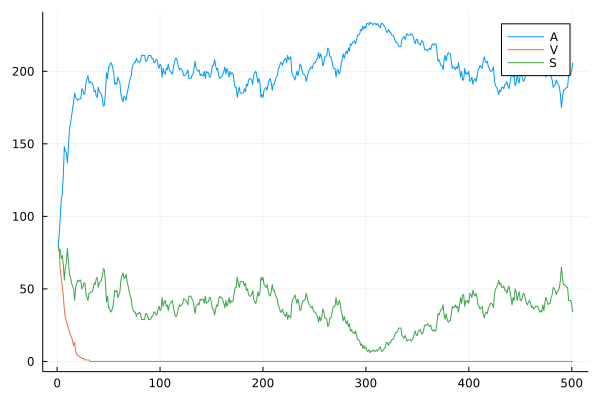

In [ ]:
rename!(merged2,:count_isaltruist => :A)
rename!(merged2,:count_isvresponsive => :V)
rename!(merged2,:count_isselfish => :S)

@df merged2 plot([:A :V :S])

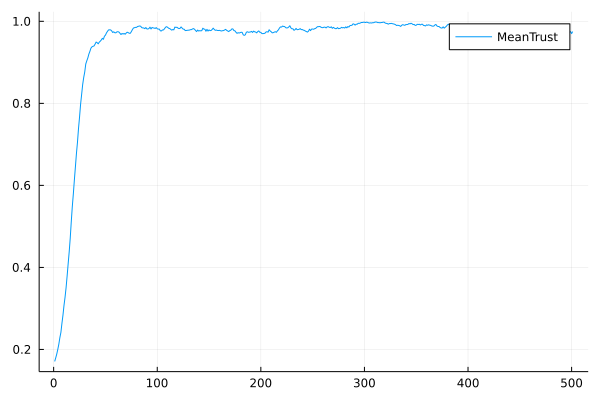

In [ ]:
rename!(merged2,:mean_trust => :MeanTrust)

@df merged2 plot([:MeanTrust], label="MeanTrust")